In [33]:
import numpy as np
import h5py
import scipy.interpolate 
import spires.legacy
import matplotlib.pyplot as plt

# SpiPy

Script to invert spectra from MODIS and estimate snow cover and properties
for 2 x 7 band pixels from a scene

# Load the verification data

In [34]:
#R is 7 band spectra for the 2 pixels
R = np.array([[0.8203,0.6796,0.8076,0.8361,0.1879,0.0321,0.0144],
              [0.4773,0.4482,0.4474,0.4823,0.1815,0.1019,0.0748]])

#R0 is the 7 band background spectra
R0 = np.array([[0.2219,0.2681,0.1016,0.1787,0.3097,0.2997,0.2970],
               [0.1377,0.2185,0.0807,0.1127,0.2588,0.2696,0.1822]])

#modis central wavelengths, for plotting
wavelengths = np.array([0.6450, 0.8585, 0.4690, 0.5550, 1.2400, 1.6400, 2.1300])

#need to sort those as the MODIS bands don't go in increasing order
idx = wavelengths.argsort(axis=0)

#matlab solutions for: 
# fractional snow cover(fsca), 
# fractional shade(fshade),
# grain size (um), 
# and dust (ppm) listed as 4 variable solution for pixel 1, then 3 variable solution for pixel 1, repeated for pixel 2

msol=np.array([[0.8848, 0.0485, 430.2819, 18.2311], 
               [0.8929, 0.1071, 367.8753, 20.1885],
               [0.4957, 0.1262, 487.8204, 55.4392], 
               [0.4942, 0.5058, 83.3307, 45.8701]])

#matlab solutions for reflectance corresponding to above
mrefl = np.array([
    [0.8173, 0.6855, 0.8166, 0.8258, 0.1848, 0.0267, 0.0230],
    [0.8143, 0.6879, 0.8194, 0.8240, 0.1865, 0.0084, 0.0040],
    [0.4828, 0.4476, 0.4524, 0.4723, 0.1814, 0.1052, 0.0706],
    [0.4681, 0.4355, 0.4653, 0.4683, 0.2307, 0.0336, 0.0174]])

#matlab RMSE (2 solutions x 2 days because the solver tries a mixed pixel (fsca, fshade, fother) and a fully snow covered pixel (fsca,fshade only), so 2 solutions for 2 days
mrmse = np.array([0.0186, 0.0326, 0.0136, 0.1055])

#solar zenith angle for both days
solar_z = np.array([24.0, 24.71])

#ideal shade endmember
shade = np.zeros(len(R[0]))

# Load Lookup table

create 4-D interpolant with the following structure 
- reflectance = F(band # (1-7))
- solar zenith angle (0-90 deg)
- dust (0-1000 ppm)
- grain radius (30-1200 um)

I've checked to make sure results are the same as MATLAB and they match

In [35]:
F = spires.legacy.load_lut('../tests/data/LUT_MODIS.mat')

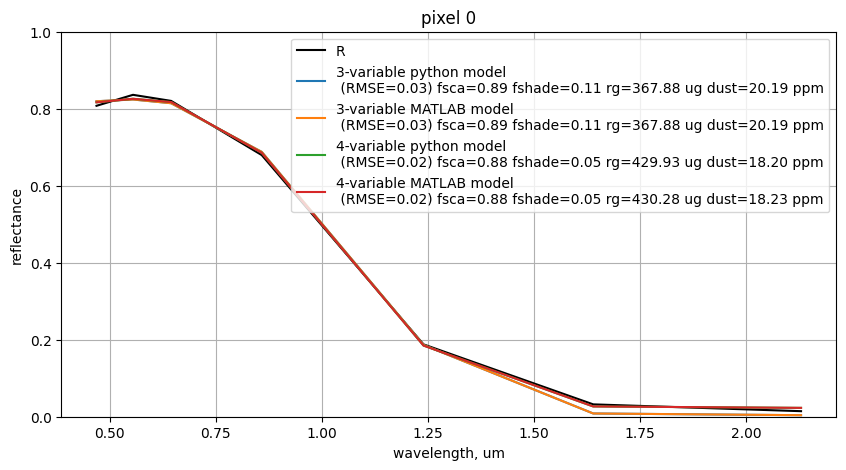

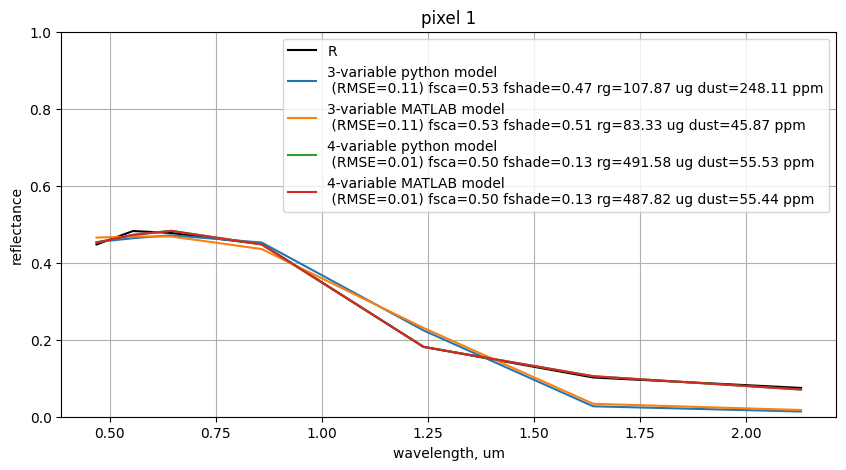

In [36]:
for i_pixel in range(0, 2):
    plt.figure(figsize=(10,5))
    plt.plot(wavelengths[idx], R[i_pixel][idx], 'k-', label='R')
    
    #run inversion
    for mode in [3, 4]:
        res, model_refl = spires.legacy.speedy_invert(F, R[i_pixel], R0[i_pixel], solar_z[i_pixel], shade, mode)
        rmse = res.fun
        fsca = res.x[0]
        fshade = res.x[1]
        rg = res.x[2]
        dust = res.x[3]
        
        if mode==4:
            mode_str = '4-variable'
        if mode==3:
            mode_str ='3-variable'
        label = mode_str +' python model\n (RMSE={rmse:0.2f}) fsca={fsca:0.2f} fshade={fshade:0.2f} rg={rg:0.2f} ug dust={dust:0.2f} ppm'
        label = label.format(rmse=rmse, fsca=fsca, fshade=fshade, rg=rg, dust=dust)        
        plt.plot(wavelengths[idx], model_refl[idx], label=label)
    
        #plot both 4 and 3 variable matlab solutions
        if mode==4:
            idt = 2*(i_pixel+1) - 2            
        elif mode==3:
            idt = 2*(i_pixel+1) - 1
        rmse  = mrmse[idt]
        fca = msol[idt][0]
        fshade = msol[idt][1]
        rg = msol[idt][2]
        dust = msol[idt][3]
        label = mode_str +' MATLAB model\n (RMSE={rmse:0.2f}) fsca={fsca:0.2f} fshade={fshade:0.2f} rg={rg:0.2f} ug dust={dust:0.2f} ppm'
        label = label.format(rmse=rmse, fsca=fsca, fshade=fshade, rg=rg, dust=dust)        
        plt.plot(wavelengths[idx], mrefl[idt][idx], label=label)

    plt.legend(loc="upper right")
    plt.title(f'pixel {i_pixel}')
    plt.ylim(0, 1)
    plt.xlabel('wavelength, um')
    plt.ylabel('reflectance')
    plt.grid('on')